Objetive: measure performance for the fine tuned model

In [1]:
import pandas as pd
import joblib
import spacy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score
import re

from src.utils import *
from src.classes import *
from src.constants import *

from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import json
import openai
# from bayer_class_db_functions import *
import warnings
warnings.filterwarnings("ignore")

### 1) Data

Clean category's names

In [2]:
df_mil=pd.read_excel('results/df_1.5k_model_scoring_final.xlsx', sheet_name='df_1.5k_model_scoring')

In [3]:
# df_mil = df_mil[df_mil['qa_label'] != "Equipment OEM Spare Parts"]
# df_mil["qa_category"] = df_mil["qa_category"].replace("fasteners", "Fasteners")

In [4]:
df_mil.qa_category.value_counts()

qa_category
Valves, Actuator, Fittings                                 239
Piping Materials                                           217
Gas, water and sewage installation                         203
Electrical Installation Materials, device                  199
Facility consumables                                       183
Fasteners                                                  175
Measurement technology, Process measurement technology     108
Equipment OEM Spare Parts                                   72
Drives                                                      72
Unclassified                                                58
Facility Consumables                                        15
fasteners                                                    6
Name: count, dtype: int64

In [5]:
df_mil["qa_category_clean"] = df_mil["qa_category"].apply(clean_header)

In [6]:
df_mil["qa_category_clean"].value_counts()

qa_category_clean
Valves, Actuator, Fittings                                239
Piping Materials                                          217
Gas, Water And Sewage Installation                        203
Electrical Installation Materials, Device                 199
Facility Consumables                                      198
Fasteners                                                 181
Measurement Technology, Process Measurement Technology    108
Equipment Oem Spare Parts                                  72
Drives                                                     72
Unclassified                                               58
Name: count, dtype: int64

### 2) Matching for the dictionaries.

Obtain performance in the matched nouns and in the non matched ones

In [51]:
import re
import unicodedata
import random
from sqlalchemy import create_engine
from langdetect import detect, LangDetectException, DetectorFactory
import openai
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import unicodedata
import json

from src.classes import *
from src.utils import *
from src.constants import *
import os
from collections import ChainMap

noun_extractor = DatabaseConnector(db_username, db_host, db_pass, db_name)
view_name = "processing.export_20250115_w_nouns"
bayer_catalog = noun_extractor.import_view(view_name)
bayer_catalog = bayer_catalog[0:10]

fine_tuned_model = "ft:gpt-4o-mini-2024-07-18:sparrow::As7oH6WH"
system_prompt = "You are a helpful assistant for product classification."
classifier = ProductClassifier(fine_tuned_model=fine_tuned_model, system_prompt=system_prompt, allowed_values=allowed_category_values)

cleaned_df = classifier.clean_data(bayer_catalog, 'verified_noun', clean_text, match_terms_exact, dict)
df_matched = cleaned_df.loc[cleaned_df['matched_category_clean'] != 'Unmatched']
df_unmatched=cleaned_df[cleaned_df['matched_category_clean']=='Unmatched']

predictions, df_model = classifier.classify_unmatched(df_unmatched=df_unmatched, predict_categories=predict_categories)


Database connection successful.
Data imported successfully from view: processing.export_20250115_w_nouns


In [53]:
df_matched

,product_id,verified_noun,quality_status,manufacturer_name,supplier_name,supplier_name_-_alternate,additional_supplier_data,manufacturer_pid,model,short_description,additional_description,long_description,supplier_pid,supplier_pid_-_alternate,noun,cleaned_noun,matched_category,matched_noun,matched_category_clean
0,101050487,cylinder,SPARROW_APPROVED,CKD,,,,SCM-FA-20B-100-T3H3-D-Z-6,SCM-FA-20B-100-T3H3-D-Z-6,air cylinder,,,,,cylinder,cylinder,"Valves, Actuator, Fittings",cylinder,"Valves, Actuator, Fittings"
1,101050486,cylinder,SPARROW_APPROVED,CKD,,,,SCM-TA-25B-50-T3H3-D-B2-6,SCM-TA-25B-50-T3H3-D-B2-6,air cylinder,,,,,cylinder,cylinder,"Valves, Actuator, Fittings",cylinder,"Valves, Actuator, Fittings"
2,101050485,cylinder,SPARROW_APPROVED,CKD,,,,SCM-CA-32B-100-T3H3-D-Y-8,SCM-CA-32B-100-T3H3-D-Y-8,air cylinder,,,,,cylinder,cylinder,"Valves, Actuator, Fittings",cylinder,"Valves, Actuator, Fittings"
3,101050484,cylinder,SPARROW_APPROVED,CKD,,,,SSD-L-160-30-T3H3-D-N-6-IN,SSD-L-160-30-T3H3-D-N-6-IN,air cylinder,,,,,cylinder,cylinder,"Valves, Actuator, Fittings",cylinder,"Valves, Actuator, Fittings"
4,101050483,cylinder,SPARROW_APPROVED,CKD,,,,SSD-KL-DB-16-40-K3H3-D-N-6-IN,SSD-KL-DB-16-40-K3H3-D-N-6-IN,air cylinder,,,,,cylinder,cylinder,"Valves, Actuator, Fittings",cylinder,"Valves, Actuator, Fittings"
5,101050482,cylinder,SPARROW_APPROVED,CKD,,,,SCM-00-20B-50-T3H3-D-Z-6,SCM-00-20B-50-T3H3-D-Z-6,air cylinder,,,,,cylinder,cylinder,"Valves, Actuator, Fittings",cylinder,"Valves, Actuator, Fittings"
6,101050481,cylinder,SPARROW_APPROVED,CKD,,,,SMG-ML-DB-20-15-K3H3-D-S165,SMG-ML-DB-20-15-K3H3-D-S165,air cylinder,,,,,cylinder,cylinder,"Valves, Actuator, Fittings",cylinder,"Valves, Actuator, Fittings"
7,101050480,cylinder,SPARROW_APPROVED,CKD,,,,SCM-00-20B-25-T3V3-H-6,SCM-00-20B-25-T3V3-H-6,air cylinder,,,,,cylinder,cylinder,"Valves, Actuator, Fittings",cylinder,"Valves, Actuator, Fittings"
8,101050479,cylinder,SPARROW_APPROVED,CKD,,,,SCM-CA-32B-25-6,SCM-CA-32B-25-6,air cylinder,,,,,cylinder,cylinder,"Valves, Actuator, Fittings",cylinder,"Valves, Actuator, Fittings"
9,101050478,cylinder,SPARROW_APPROVED,CKD,,,,SCM-TA-20B-100-T3V3-D-Z-B2-6,SCM-TA-20B-100-T3V3-D-Z-B2-6,air cylinder,,,,,cylinder,cylinder,"Valves, Actuator, Fittings",cylinder,"Valves, Actuator, Fittings"


In [47]:
with open('dictionaries/dict_de.json', 'r') as f:
    dict_de = json.load(f)

In [7]:
with open('dictionaries/dict_de.json', 'r') as f:
    dict_de = json.load(f)

with open('dictionaries/dict_en.json', 'r') as f:
    dict_en = json.load(f)

with open('dictionaries/dict_es.json', 'r') as f:
    dict_es = json.load(f)

dict = dict_de.copy()  # Make a copy to avoid modifying the original
dict.update(dict_en)
dict.update(dict_es)

In [14]:
df_mil=df_mil.iloc[0:10]

In [8]:
# dict = {key: value for key, value in dict.items() if value != 'Equipment OEM Spare Parts'}

In [15]:
unique_categories = set(dict.values())
num_categories = len(unique_categories)
print(f"Number of unique categories: {num_categories}")
print(f"Categories: {unique_categories}")

Number of unique categories: 9
Categories: {'Electrical Installation Materials, device', 'Piping Materials', 'Equipment OEM Spare Parts', 'Measurement technology, Process measurement technology ', 'Valves, Actuator, Fittings', 'Fasteners', 'Drives', 'Facility consumables', 'Gas, water and sewage installation'}


In [23]:
dict

{'wechselstrommotoren': 'Drives',
 'nockenring': 'Drives',
 'motorreductor': 'Drives',
 'motorreduktor': 'Drives',
 'drehstrommotor': 'Drives',
 'motorbaugruppe': 'Drives',
 'motor modul': 'Drives',
 'schraubenmotor': 'Drives',
 'schrittmotor': 'Drives',
 'schrittmotormodul': 'Drives',
 'zahnrad': 'Drives',
 'getriebesteckwelle': 'Drives',
 'türantrieb': 'Drives',
 'achse': 'Drives',
 'antriebswelle': 'Drives',
 'getriebemotor': 'Drives',
 'antriebsstange': 'Drives',
 'antriebsriemen': 'Drives',
 'ausgleichkupplung': 'Drives',
 'ausgleichskupplung': 'Drives',
 'einzelmotor-modul': 'Drives',
 'flachriemen': 'Drives',
 'flexo kupplung': 'Drives',
 'flexokupplung': 'Drives',
 'getriebe': 'Drives',
 'getriebeübersetzung': 'Drives',
 'gliederkeilriemen': 'Drives',
 'hochleistungsflachriemen': 'Drives',
 'kegelradgetriebe': 'Drives',
 'kegelstirnradgetriebe': 'Drives',
 'keilriemen': 'Drives',
 'keilriemenrad': 'Drives',
 'keilrippenriemen': 'Drives',
 'keilrscheibe': 'Drives',
 'kette': 'Dr

In [16]:
fine_tuned_model = "ft:gpt-4o-mini-2024-07-18:sparrow::As7oH6WH"
system_prompt = "You are a helpful assistant for product classification."
classifier = ProductClassifier(fine_tuned_model=fine_tuned_model, system_prompt=system_prompt, allowed_values=allowed_category_values)

In [17]:
predictions, df_model = classifier.classify_unmatched(df_unmatched=df_mil, predict_categories=predict_categories)

In [18]:
df_model_metrics=df_model[df_model['qa_category_clean']!='Unclassified']

In [19]:
# fine_tuned_model = "ft:gpt-4o-mini-2024-07-18:sparrow::As7oH6WH"
# system_prompt = "You are a helpful assistant for product classification."

# classifier = ProductClassifier(
#     fine_tuned_model=fine_tuned_model,
#     system_prompt=system_prompt,
#     allowed_values=allowed_category_values)

In [24]:
df_mil.head()

,product_id,code_flag,quality_status,manufacturer_name,manufacturer_pid,model,short_description,translation,long_description,additional_description,noun,norm,qa_category,review,comment,reviewed_by,qa_category_clean,predictions_model,predictions_model_clean
0,61656711,False,TO_REVIEW,MLR System GmbH,168609793,NaN,Bumper vorne f.FTF,Front bumper FFTF MLR 168609793 designation bu...,Bumper vorne f.FTF; MLR 168609793; Benennung: ...,Benennung: Bumper (Stoßfänger); für: f.FTF; Ar...,Bumper,NaN,Unclassified,Bumper,NaN,NaN,Unclassified,"Doors, Hinge door","Doors, Hinge Door"
1,61581991,False,TO_REVIEW,General Electric,29096425,NaN,"DISTRIBUTOR:TOP,CERTIFICATE OF CONFORMIT",Distributor top certificate of conformity 2909...,"DISTRIBUTOR:TOP,CERTIFICATE OF CONFORMIT; 2909...","DISTRIBUTOR:TOP,CERTIFICATE OF CONFORMITY REQU...",DISTRIBUTOR,NaN,Unclassified,Distributor,NaN,NaN,Unclassified,"Electrical Installation Materials, device","Electrical Installation Materials, Device"
2,62061846,False,TO_REVIEW,Fette,2136944,NaN,Machine Distributor A3/1 X098,Machine distributor A3 1 X098 Fette 2136944,Machine Distributor A3/1 X098; FETTE 2136944;,NaN,Machine Distributor,NaN,Unclassified,Distributor,NaN,NaN,Unclassified,"Electrical Installation Materials, device","Electrical Installation Materials, Device"
3,101038553,False,NaN,IFM,E10802,NaN,Y-Verteiler,Y-distributor,NaN,NaN,Y-Verteiler,NaN,Unclassified,Distributor,NaN,NaN,Unclassified,Piping Materials,Piping Materials
4,61836739,False,SPARROW_PROCESSING,NaN,NaN,RG5-5064,KIT FUSION HP4100 RG5-5064,Kit fusion HP4100 RG5 5064,KIT FUSION HP4100 RG5-5064; ;,NaN,KIT,NaN,Unclassified,Fusion kit,NaN,NaN,Unclassified,"Gas, water and sewage installation","Gas, Water And Sewage Installation"


In [27]:
cleaned_df = classifier.clean_data(df_mil, 'noun', clean_text, match_terms_not_exact, dict)
df_unmatched=cleaned_df[cleaned_df['matched_category_clean']=='Unmatched']
predictions, df_unmatched_updated = classifier.classify_unmatched(df_unmatched=df_unmatched, predict_categories=predict_categories)
df_matched = cleaned_df[(cleaned_df['qa_category_clean'] != 'Unclassified') & (cleaned_df['matched_category_clean'] != 'Unmatched')]

In [28]:
# df_combined, metrics = classifier.compute_metrics_and_combine(df_matched=df_matched,df_unmatched=df_unmatched_updated,compute_metrics=compute_metrics)

AttributeError: 'ProductClassifier' object has no attribute 'compute_metrics_and_combine'

In [46]:
unmatched_true = df_unmatched_updated['qa_category_clean'].tolist()
unmatched_pred = df_unmatched_updated['predictions_model_clean'].tolist()
metrics = compute_metrics(unmatched_true, unmatched_pred)
print(metrics["classification_report"])

Accuracy: 0.00

Classification Report:
                                           precision    recall  f1-score   support

Electrical Installation Materials, Device       0.00      0.00      0.00       0.0
                Equipment Oem Spare Parts       0.00      0.00      0.00       0.0
                     Facility Consumables       0.00      0.00      0.00       0.0
       Gas, Water And Sewage Installation       0.00      0.00      0.00       0.0
                         Piping Materials       0.00      0.00      0.00       0.0
                             Unclassified       0.00      0.00      0.00       7.0

                                 accuracy                           0.00       7.0
                                macro avg       0.00      0.00      0.00       7.0
                             weighted avg       0.00      0.00      0.00       7.0



### 3) Classes

Apply all classes created in this case

In [31]:
db_username = "postgres"
db_host = "scrapperdb-instance-1.c9sspr3fqhgw.eu-central-1.rds.amazonaws.com"
db_pass = "2wff4gr3j546"
db_name = "BAYER"

In [33]:
noun_extractor = DatabaseConnector(db_username, db_host, db_pass, db_name)
view_name = "processing.export_20250115_w_nouns"
bayer_catalog = noun_extractor.import_view(view_name)

Database connection successful.
Data imported successfully from view: processing.export_20250115_w_nouns


In [27]:
# noun_extractor = NounExtractor(db_username, db_host, db_pass, db_name)
# view_name = "processing.class_noun_assigned_20250123"
# matched_nouns = noun_extractor.import_view(view_name)

Database connection successful.
Data imported successfully from view: processing.class_noun_assigned_20250123


In [ ]:
fine_tuned_model = "ft:gpt-4o-mini-2024-07-18:sparrow::As7oH6WH"
system_prompt = "You are a helpful assistant for product classification."
classifier = ProductClassifier(fine_tuned_model=fine_tuned_model,system_prompt=system_prompt,allowed_values=allowed_category_values)

# df_trial=bayer_catalog.iloc[0:10]
cleaned_df = classifier.clean_data(bayer_catalog, 'verified_noun', clean_text, match_terms_exact, dict)
df_matched = cleaned_df.loc[cleaned_df['matched_category_clean'] != 'Unmatched']
df_unmatched=cleaned_df[cleaned_df['matched_category_clean']=='Unmatched']

# predictions, df_unmatched_updated = classifier.classify_unmatched(df_unmatched=df_unmatched, predict_categories=predict_categories)

In [36]:
df_unmatched.shape

(223109, 19)

In [37]:
df_matched.shape

(258017, 19)

In [39]:
df=pd.read_csv('results/df_exact_matched.csv')

In [40]:
df.shape

(242663, 21)

In [41]:
df_matched.shape

(258017, 19)

In [42]:
df_unmatched.quality_status.value_counts()

quality_status
CLARIFICATION_NEEDED    106737
TO_REVIEW                88194
SPARROW_APPROVED         15324
SPARROW_PROCESSING        5508
SPARROW_IN_PROGRESS       3977
SPARROW_REVIEWED          2856
SPARROW_TO_REVIEW          252
CUSTOMER_IN_PROGRESS       149
CUSTOMER_APPROVED           79
CUSTOMER_FEEDBACK           33
Name: count, dtype: int64

In [44]:
# processed_df = noun_extractor.process_nouns(df_matched, 'matched_category_clean')
# table_name = "class_noun_assigned_20250123"

In [63]:
noun_extractor.upload_to_database(processed_df, table_name)

Data uploaded successfully to processing.class_noun_assigned_20250123


In [28]:
df_matched_exact=df_matched.copy()

### Last Review of Parts

In [32]:
# final_review_matched = matched_nouns.merge(
#     df_qa[['product_id', 'predicted_classification', 'qa_category']],
#     on='product_id',
#     how='left')
# matching_products.head()

In [39]:
df=pd.read_excel('noun_qa_final.xlsx')

In [40]:
def clean_header(text):
    text = " ".join(text.split())  # Remove double spaces
    return text.title()  # Capitalize each word

In [41]:
df["qa_category_clean"] = df['qa_category'].apply(clean_header)
df["predicted_classification_clean"] = df['predicted_classification'].apply(clean_header)

In [51]:
df = df.merge(
    bayer_catalog[['product_id', 'quality_status']],  # Selecting relevant columns from bayer_catalog
    on='product_id',  # Matching based on product_id
    how='left'  # Keeping all records from df and adding quality_status where a match is found
)

In [52]:
df.head()

,product_id,short_description,verified_noun,predicted_classification,qa_category,Comments,qa_category_clean,predicted_classification_clean,quality_status
0,61599132,ANALYZER:CONDUCTIVITY,ANALYZER,"Electrical Installation Materials, Device","Electrical Installation Materials, Device",NaN,"Electrical Installation Materials, Device","Electrical Installation Materials, Device",TO_REVIEW
1,61454951,Abrazadera cadmiada 16*25mm.,Abrazadera,Fasteners,Fasteners,NaN,Fasteners,Fasteners,CLARIFICATION_NEEDED
2,61789513,ABRAZADERA;4in;,ABRAZADERA,Fasteners,Fasteners,NaN,Fasteners,Fasteners,CLARIFICATION_NEEDED
3,61660150,"Berstscheibe FDA SU-C-S DN 50 6,0 barü",Berstscheibe,Piping Materials,Piping Materials,NaN,Piping Materials,Piping Materials,TO_REVIEW
4,61995676,Absolutdrucktransmitter,Absolutdrucktransmitter,"Measurement Technology, Process Measurement Te...","Measurement technology, Process measurement te...",NaN,"Measurement Technology, Process Measurement Te...","Measurement Technology, Process Measurement Te...",TO_REVIEW


In [55]:
# Ensure the 'quality_status' column exists in the DataFrame
if 'quality_status' in df.columns:
    # Define the two groups
    clarification_needed_group = df[df['quality_status'] == 'CLARIFICATION_NEEDED']
    rest_group = df[df['quality_status'] != 'CLARIFICATION_NEEDED']

    # Compute accuracy for CLARIFICATION_NEEDED
    unmatched_true_clarification = clarification_needed_group['qa_category_clean'].tolist()
    unmatched_pred_clarification = clarification_needed_group['predicted_classification_clean'].tolist()
    correct_clarification = sum(1 for true, pred in zip(unmatched_true_clarification, unmatched_pred_clarification) if true == pred)
    accuracy_clarification = correct_clarification / len(unmatched_true_clarification) if unmatched_true_clarification else 0

    # Compute accuracy for the REST group
    unmatched_true_rest = rest_group['qa_category_clean'].tolist()
    unmatched_pred_rest = rest_group['predicted_classification_clean'].tolist()
    correct_rest = sum(1 for true, pred in zip(unmatched_true_rest, unmatched_pred_rest) if true == pred)
    accuracy_rest = correct_rest / len(unmatched_true_rest) if unmatched_true_rest else 0

    # Print accuracy results
    print(f"Accuracy for CLARIFICATION_NEEDED: {accuracy_clarification:.4f}")
    print(f"Accuracy for REST: {accuracy_rest:.4f}")

else:
    print("Column 'quality_status' not found in the DataFrame.")

Accuracy for CLARIFICATION_NEEDED: 0.9206
Accuracy for REST: 0.9353


### Matching categories and the IDs

In [ ]:
df_categories_names = pd.DataFrame(columns=['product_id', 'category'])

In [ ]:
df_categories_names['product_id'] = [101, 102, 103, 104, 105]
df_categories_names['category'] = ['Electronics', 'Clothing', 'Home Appliances', 'Books', 'Toys']

** Some results

In [556]:
all_view_df.verified_noun.value_counts()

verified_noun
bearing                             257
flowmeter                            98
fan                                  67
Elbow                                57
Bearing                              49
insert                               41
Valve                                37
Gasket                               28
file                                 27
Pump                                 17
Filter Cartridge                     17
Hose                                 15
Belt                                 15
Adapter                              15
Latrolet                             14
gasket                               11
Fitting                              11
Battery                              11
Washer                               11
Solid State Relay                    10
Circuit Breaker                       9
ball bearing                          9
Controller                            9
Water Pump                            8
Blind Flange              

In [ ]:
df_test = df_new[(df_new['qa_category_clean'] != 'Unclassified') & (df_new['matched_category_clean'] != 'Unmatched')]
true_labels = df_test['qa_category_clean'].tolist()
predicted_labels = df_test['matched_category_clean'].tolist()
metrics = compute_metrics(true_labels, predicted_labels)

Accuracy: 0.90

Classification Report:
                                                        precision    recall  f1-score   support

                                                Drives       0.84      0.82      0.83        51
             Electrical Installation Materials, Device       0.89      0.93      0.91       120
                             Equipment Oem Spare Parts       0.92      0.50      0.65        46
                                  Facility Consumables       0.86      0.92      0.89       135
                                             Fasteners       0.89      0.95      0.92        94
                    Gas, Water And Sewage Installation       0.89      0.91      0.90       137
Measurement Technology, Process Measurement Technology       0.92      0.72      0.81        64
                                      Piping Materials       0.97      0.98      0.98       189
                            Valves, Actuator, Fittings       0.90      0.96      0.93       141


In [ ]:
df_unmatched["qa_category_clean"] = df_unmatched['qa_category'].apply(clean_text)
df_unmatched["predictions_model_clean"] = df_unmatched['predictions_model'].apply(clean_text)
true_labels = df_unmatched['qa_category_clean'].tolist()
predicted_labels = df_unmatched['predictions_model_clean'].tolist()
metrics = compute_metrics(true_labels, predicted_labels)

Accuracy: 0.63

Classification Report:
                                                        precision    recall  f1-score   support

                                                Drives       0.62      0.38      0.47        21
             Electrical Installation Materials, Device       0.64      0.89      0.74        79
                             Equipment Oem Spare Parts       0.31      0.19      0.24        26
                                  Facility Consumables       0.75      0.76      0.76        63
                                             Fasteners       0.52      0.82      0.63        87
                    Gas, Water And Sewage Installation       0.70      0.68      0.69        66
Measurement Technology, Process Measurement Technology       0.91      0.68      0.78        44
                                      Piping Materials       0.38      0.64      0.47        28
                                          Unclassified       0.00      0.00      0.00        53


C:\Users\RodrigoMartínezAlons\AppData\Local\Temp\ipykernel_26944\1310572569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unmatched["qa_category_clean"] = df_unmatched['qa_category'].apply(clean_text)
C:\Users\RodrigoMartínezAlons\AppData\Local\Temp\ipykernel_26944\1310572569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unmatched["predictions_model_clean"] = df_unmatched['predictions_model'].apply(clean_text)
c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_class

In [ ]:
df_combined = df_combined[(df_combined['qa_category_clean'] != 'Unclassified')]
true_labels = df_combined['qa_category_clean'].tolist()
predicted_labels = df_combined['final_category'].tolist()
metrics = compute_metrics(true_labels, predicted_labels)

Accuracy: 0.83

Classification Report:
                                                        precision    recall  f1-score   support

                                                Drives       0.79      0.69      0.74        72
             Electrical Installation Materials, Device       0.81      0.91      0.86       199
                             Equipment Oem Spare Parts       0.74      0.39      0.51        72
                                  Facility Consumables       0.83      0.87      0.85       198
                                             Fasteners       0.74      0.88      0.81       181
                    Gas, Water And Sewage Installation       0.84      0.83      0.84       203
Measurement Technology, Process Measurement Technology       0.94      0.70      0.80       108
                                      Piping Materials       0.86      0.94      0.90       217
                            Valves, Actuator, Fittings       0.87      0.82      0.84       239


In [ ]:
df_combined.shape

(1489, 24)

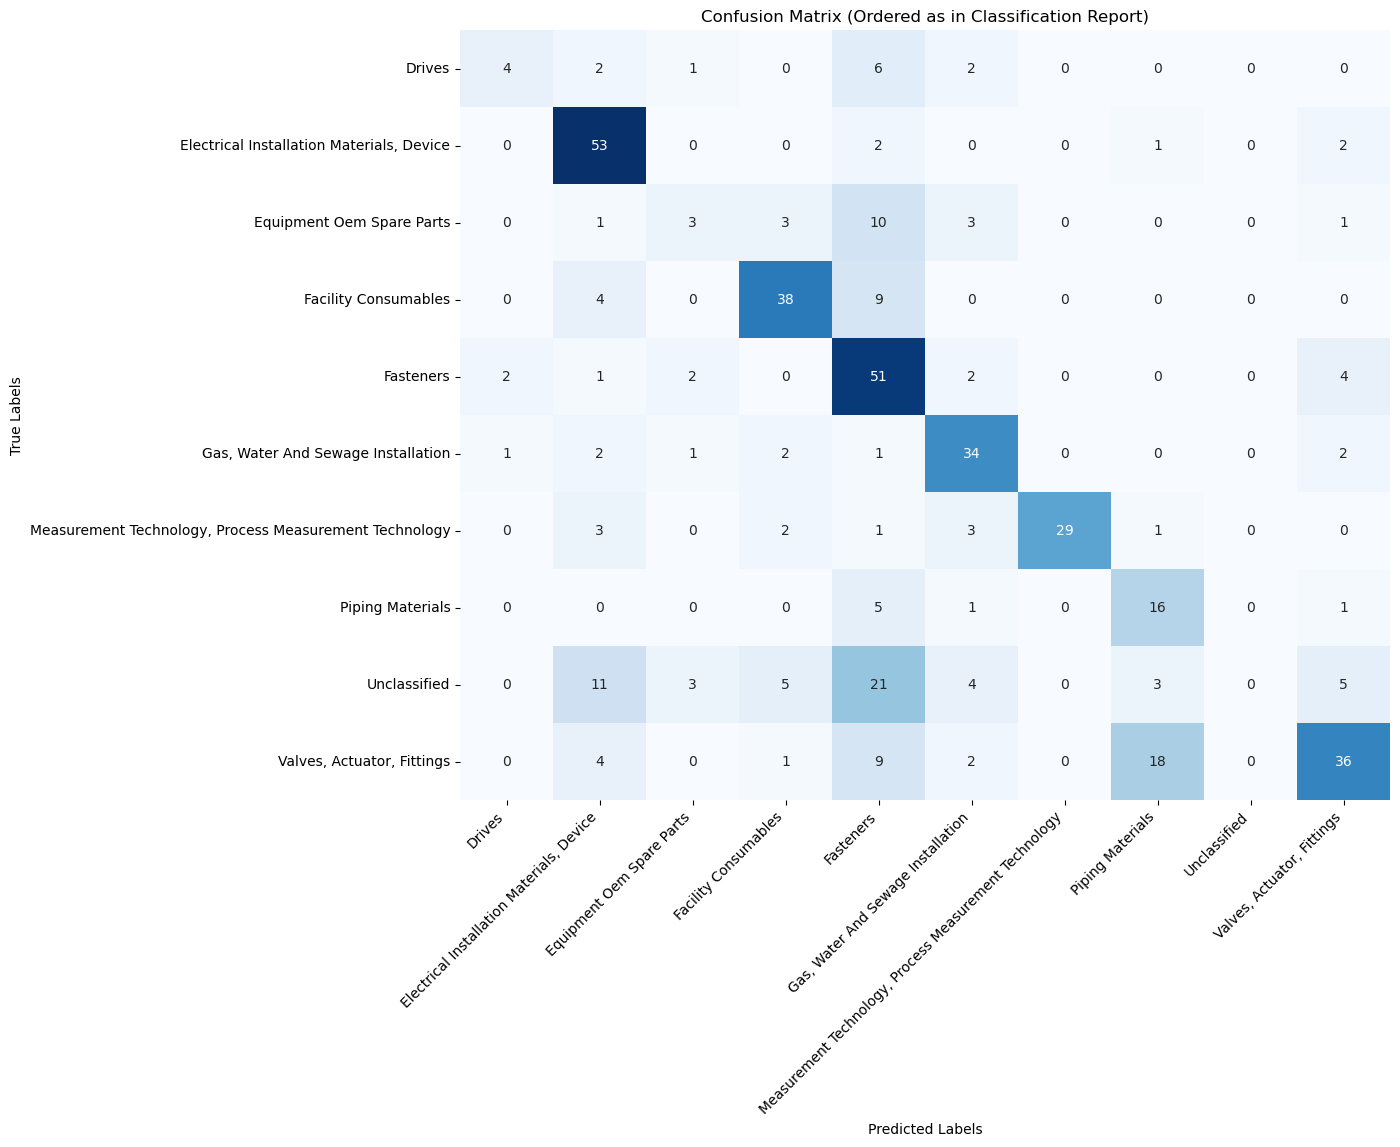

In [326]:
labels_in_report_order = [
    "Drives",
    "Electrical Installation Materials, Device",
    "Equipment Oem Spare Parts",
    "Facility Consumables",
    "Fasteners",
    "Gas, Water And Sewage Installation",
    "Measurement Technology, Process Measurement Technology",
    "Piping Materials",
    "Unclassified",
    "Valves, Actuator, Fittings"
]

# Your confusion matrix (replace with actual values if different)
matrix = [
    [4, 2, 1, 0, 6, 2, 0, 0, 0, 0],
    [0, 53, 0, 0, 2, 0, 0, 1, 0, 2],
    [0, 1, 3, 3, 10, 3, 0, 0, 0, 1],
    [0, 4, 0, 38, 9, 0, 0, 0, 0, 0],
    [2, 1, 2, 0, 51, 2, 0, 0, 0, 4],
    [1, 2, 1, 2, 1, 34, 0, 0, 0, 2],
    [0, 3, 0, 2, 1, 3, 29, 1, 0, 0],
    [0, 0, 0, 0, 5, 1, 0, 16, 0, 1],
    [0, 11, 3, 5, 21, 4, 0, 3, 0, 5],
    [0, 4, 0, 1, 9, 2, 0, 18, 0, 36]
]

# Plot the confusion matrix
plot_confusion_matrix_with_report_order(matrix, labels_in_report_order)

** Obtain performance metrics

#### 4.1) For all columns with matches. 

Matched and predicted columns

In [73]:
allowed_values = [
    "Piping Materials",
    "Electrical Installation Materials",
    "Valves, Actuator, Fittings",
    "Gas, Water and Sewage Installation",
    "Fasteners",
    "Facility Consumables",
    "Measurement technology, Process measurement technology",
    "Drives",
    "Unclassified",
    "Equipment OEM Spare Parts"]

df_filtered = df_mil[df_mil["pred_cat_gen_eng"].isin(allowed_values)]

In [74]:
df_filtered["pred_cat_gen_eng"].value_counts()

pred_cat_gen_eng
Piping Materials                                          411
Electrical Installation Materials                         239
Valves, Actuator, Fittings                                214
Gas, Water and Sewage Installation                        164
Fasteners                                                 144
Facility Consumables                                      138
Measurement technology, Process measurement technology     82
Drives                                                     43
Unclassified                                               42
Equipment OEM Spare Parts                                   8
Name: count, dtype: int64

In [75]:
df_filtered['qa_category'].value_counts()

qa_category
Valves, Actuator, Fittings                                221
Piping Materials                                          218
Electrical Installation Materials                         204
Fasteners                                                 198
Gas, Water and Sewage Installation                        194
Facility Consumables                                      175
Measurement technology, Process measurement technology    108
Drives                                                     72
Unclassified                                               57
Equipment OEM Spare Parts                                  38
Name: count, dtype: int64

In [80]:
predicted = df_filtered['pred_cat_gen_eng']
qa_label = df_filtered['qa_category']

In [36]:
predicted = df_mil['predicted_category']
matched = df_mil['matched_category']
qa_label = df_mil['qa_label']
valid_matched = ~matched.isna()

KeyError: 'predicted_category'

In [219]:
accuracy = accuracy_score(matched[valid_matched], predicted[valid_matched])
report = classification_report(matched[valid_matched], predicted[valid_matched])
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.97

Classification Report:
                                           precision    recall  f1-score   support

Electrical Installation Materials, device       0.96      0.98      0.97       162
                Equipment OEM Spare Parts       0.00      0.00      0.00         0
                     Facility consumables       1.00      0.86      0.93        22
                                Fasteners       0.98      0.99      0.98       361
       Gas, water and sewage installation       0.98      0.94      0.96        85
                         Piping Materials       1.00      0.93      0.96        58
               Valves, Actuator, Fittings       0.95      0.95      0.95       131

                                 accuracy                           0.97       819
                                macro avg       0.84      0.81      0.82       819
                             weighted avg       0.97      0.97      0.97       819



c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [220]:
# df_mil.to_csv('df_mil_embeddings.csv')

Adam reviews (qa_label) and predicted values

In [221]:
report = classification_report(qa_label[valid_matched], predicted[valid_matched])
print("\nClassification Report:")
print(report)


Classification Report:
                                           precision    recall  f1-score   support

Electrical Installation Materials, device       0.93      0.89      0.91       174
                Equipment OEM Spare Parts       0.00      0.00      0.00         0
                     Facility consumables       0.89      0.71      0.79        24
                                Fasteners       0.86      0.99      0.92       319
       Gas, water and sewage installation       0.84      0.79      0.82        87
                         Piping Materials       1.00      0.83      0.91        65
               Valves, Actuator, Fittings       0.95      0.83      0.89       150

                                 accuracy                           0.90       819
                                macro avg       0.78      0.72      0.75       819
                             weighted avg       0.90      0.90      0.90       819



c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Adam reviews and matched

In [222]:
report = classification_report(qa_label[valid_matched], matched[valid_matched])
print("\nClassification Report:")
print(report)


Classification Report:
                                           precision    recall  f1-score   support

Electrical Installation Materials, device       0.94      0.87      0.90       174
                     Facility consumables       0.82      0.75      0.78        24
                                Fasteners       0.87      0.98      0.92       319
       Gas, water and sewage installation       0.84      0.82      0.83        87
                         Piping Materials       0.95      0.85      0.89        65
               Valves, Actuator, Fittings       0.95      0.83      0.89       150

                                 accuracy                           0.90       819
                                macro avg       0.89      0.85      0.87       819
                             weighted avg       0.90      0.90      0.90       819



#### 4.2) Check for the unmatched nouns

In [234]:
nan_matched = matched.isna()
report = classification_report(qa_label[nan_matched], predicted[nan_matched])
print("\nClassification Report:")
print(report)


Classification Report:
                                           precision    recall  f1-score   support

Electrical Installation Materials, device       0.73      0.50      0.59        16
                     Facility consumables       0.20      0.33      0.25         3
                                Fasteners       0.67      0.80      0.73        10
       Gas, water and sewage installation       0.56      0.56      0.56         9
                         Piping Materials       0.50      0.50      0.50         2
               Valves, Actuator, Fittings       0.62      0.71      0.67         7

                                 accuracy                           0.60        47
                                macro avg       0.55      0.57      0.55        47
                             weighted avg       0.62      0.60      0.60        47



#### 4.3) For all values

All values with the model

In [60]:
df_filtered.head(2)

,product_id,code_flag,quality_status,manufacturer_name,manufacturer_pid,model,short_description,translation,long_description,additional_description,noun,norm,qa_category,review,comment,reviewed_by,pred_cat_gen_eng
0,61656711,False,TO_REVIEW,MLR System GmbH,168609793,NaN,Bumper vorne f.FTF,Front bumper FFTF MLR 168609793 designation bu...,Bumper vorne f.FTF; MLR 168609793; Benennung: ...,Benennung: Bumper (Stoßfänger); für: f.FTF; Ar...,Bumper,NaN,Unclassified,Bumper,NaN,NaN,Facility Consumables
1,61581991,False,TO_REVIEW,General Electric,29096425,NaN,"DISTRIBUTOR:TOP,CERTIFICATE OF CONFORMIT",Distributor top certificate of conformity 2909...,"DISTRIBUTOR:TOP,CERTIFICATE OF CONFORMIT; 2909...","DISTRIBUTOR:TOP,CERTIFICATE OF CONFORMITY REQU...",DISTRIBUTOR,NaN,Unclassified,Distributor,NaN,NaN,Facility Consumables


In [79]:
df_filtered[df_filtered['pred_cat_gen_eng']=='Measurement technology, Process measurement technology'].head(2)

,product_id,code_flag,quality_status,manufacturer_name,manufacturer_pid,model,short_description,translation,long_description,additional_description,noun,norm,qa_category,review,comment,reviewed_by,pred_cat_gen_eng
52,62036958,False,SPARROW_PROCESSING,Rembe,139-9991001088,NaN,Set Tellereinheit Überdruck,Set plate unit overpressure REMBE 139 99910010...,Set Tellereinheit Überdruck; REMBE 139-9991001...,Benennung: Set Tellereinheit; Art/Ausführung: ...,Set,NaN,Unclassified,Weak identifier,NaN,NaN,"Measurement technology, Process measurement te..."
64,61712030,True,TO_REVIEW,THERMO ENVIRONMENTAL,DWG 96P71652,96P71652,"RACK:ANALYZER,90"",DWG 96P71652,THERMO EN",Rack analyzer 90 DWG 96P71652 thermo in rack a...,"RACK:ANALYZER,90"",DWG 96P71652,THERMO EN; ; RA...","RACK: ANALYZER TYPE, 90"" SIZE, THERMO; ENVIRON...",RACK,NaN,Facility Consumables,Analyzer Rack,NaN,NaN,"Measurement technology, Process measurement te..."


In [78]:
df_filtered[df_filtered['qa_category']=='Measurement technology, Process measurement technology'].head(2)

,product_id,code_flag,quality_status,manufacturer_name,manufacturer_pid,model,short_description,translation,long_description,additional_description,noun,norm,qa_category,review,comment,reviewed_by,pred_cat_gen_eng
90,61633025,True,SPARROW_APPROVED,FESTO,10773,PEV-1/4-B,Druckschalter,Festo pressure switch code 10773 Symex GmbH Co...,Festo Pressure Switch Code 10773; SYMEX GMBH &...,NaN,Druckschalter,EN 60947-5-1,"Measurement technology, Process measurement te...",Festo,NaN,NaN,"Measurement technology, Process measurement te..."
102,101033091,True,SPARROW_PROCESSING,Sony,LT20-201C,LT20-201C,"DISPLAY, STANDARD, SONY GAUGE DISPLAY 2 AXIS +...",Wetland,NaN,NaN,DISPLAY,NaN,"Measurement technology, Process measurement te...",gauge display,NaN,NaN,"Measurement technology, Process measurement te..."


In [81]:
accuracy = accuracy_score(qa_label, predicted)
report = classification_report(qa_label, predicted)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.68

Classification Report:
                                                        precision    recall  f1-score   support

                                                Drives       0.84      0.50      0.63        72
                     Electrical Installation Materials       0.75      0.88      0.81       204
                             Equipment OEM Spare Parts       0.50      0.11      0.17        38
                                  Facility Consumables       0.80      0.63      0.70       175
                                             Fasteners       0.78      0.57      0.66       198
                    Gas, Water and Sewage Installation       0.68      0.58      0.63       194
Measurement technology, Process measurement technology       0.87      0.66      0.75       108
                                      Piping Materials       0.52      0.98      0.68       218
                                          Unclassified       0.50      0.37      0.42        57


In [97]:
df_mil.to_excel('results/df_Adam_gpt_general_terms_en.xlsx')

In [225]:
predicted = df_mil['predicted_category']
matched = df_mil['matched_category']
qa_label = df_mil['qa_label']
valid_matched = ~matched.isna()

In [226]:
df_mil['matched_category'] = df_mil['matched_category'].fillna('undefined')
matched_non_nan = df_mil['matched_category']


In [227]:
report = classification_report(matched_non_nan, qa_label)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.88

Classification Report:
                                           precision    recall  f1-score   support

Electrical Installation Materials, device       0.80      0.94      0.86       162
                     Facility consumables       0.67      0.82      0.73        22
                                Fasteners       0.95      0.87      0.91       361
       Gas, water and sewage installation       0.74      0.84      0.78        85
                         Piping Materials       0.82      0.95      0.88        58
               Valves, Actuator, Fittings       0.80      0.95      0.87       131
                                undefined       0.00      0.00      0.00        47

                                 accuracy                           0.85       866
                                macro avg       0.68      0.77      0.72       866
                             weighted avg       0.81      0.85      0.83       866



c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RodrigoMartínezAlons\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [228]:
df_mismatch = df_mil[df_mil['predicted_category'] != df_mil['qa_label']]
# df_mismatch = df_mismatch.dropna(subset=['predicted_category'])
# Remove rows where 'predicted_category' is None or NaN
df_mismatch = df_mismatch[df_mismatch['matched_category'].notna()]
df_mismatch.shape

(104, 32)

In [229]:
df_mismatch.cleaned_noun.value_counts()

cleaned_noun
ball valve          7
connectors          6
connector           6
joint               4
faltenbalg          4
                   ..
dcaxiallüfter       1
dowel               1
drucksensor         1
flammensicherung    1
zentralbaugr        1
Name: count, Length: 76, dtype: int64

In [339]:
df_mismatch.head()

,rm_index,product_id,quality_status,manufacturer_name,manufacturer_pid,model,short_description,long_description,additional_description,noun,...,predicted_category,qa_category,review,comment,reviewed_by,prompt_text,Translation,Analysis,match,predicted_category_gpt
5,96290,61992152,SPARROW_PROCESSING,NaN,NaN,DB721,Alarm Detector Base DB721,Alarm Detector Base DB721; ;,NaN,Base,...,"Electrical Installation Materials, device","Electrical Installation Materials, device",NaN,NaN,AC,alarm detector base db721,Alarm detector base DB721,"Step 1: The input ""alarm detector base db721"" ...",True,Fasteners
14,209528,61844071,CLARIFICATION_NEEDED,Kastle Waterjet LLC,NaN,NaN,"BASE,PUMP STORAGE,ANSI SIZES AA & AB","BASE,PUMP STORAGE,ANSI SIZES AA & AB; ; BASE, ...","BASE, PUMP STORAGE, ANSI FRAME DESIGNATIONS AA...",BASE,...,"Electrical Installation Materials, device","Electrical Installation Materials, device",NaN,NaN,AC,base pump storage ansi sizes aa ab base pump s...,base pump storage ANSI sizes AA AB base pump s...,"Output: [Gas, water and sewage installation]\n...",True,Fasteners
15,342203,61710216,TO_REVIEW,CON-SERVE INC,NaN,NaN,"BASE:SLIDE BEARING,CON-SERVE,18C-12844","BASE:SLIDE BEARING,CON-SERVE,18C-12844; ; BASE...","BASE: SLIDE BEARING TYPE, 304 SS AND CS MATERI...",BASE,...,"Electrical Installation Materials, device","Electrical Installation Materials, device",NaN,NaN,AC,base slide bearing con serve 18c 12844 base sl...,"Base slide bearing, con serve 18c 12844 base s...",Input: base slide bearing con serve 18c 12844 ...,True,Fasteners
51,415914,61636042,SPARROW_APPROVED,SIEMENS,QBM3020-1U,QBM3020-1U,Diff Pressure Switch Dc 0 10V/50 + 50 Pa,Diff Pressure Switch Dc 0 10V/50 + 50 Pa; SIEM...,NaN,Diff Pressure Switch,...,"Electrical Installation Materials, device","Electrical Installation Materials, device",NaN,NaN,AC,diff pressure switch dc 0 10v 50 50 pa siemens...,Differential pressure switch DC 0-10V 50-50 Pa...,"Classification: [Gas, water and sewage install...",True,"Gas, water and sewage installation"
62,96288,61992158,SPARROW_PROCESSING,Signal Technik Sprenger,NaN,STS 106K,"Flow Controller Sensor G3/4"" 2m STS 106K","Flow Controller Sensor G3/4"" 2m STS 106K; ;",NaN,Flow Controller Sensor,...,"Electrical Installation Materials, device","Electrical Installation Materials, device",Gas Water?,Could be either group.,AC,flow controller sensor g3 4 2m sts 106k,Flow controller sensor G3 4 2m STS 106k,Step 1: The input text describes a flow contro...,True,"Gas, water and sewage installation"


### 5) Prediction for the spanish non matched nouns using gpt fine tuned only in German

In [343]:
# df_nouns=pd.read_excel('df_nouns_spanish_review_gpt.xlsx')

### 6) Verification file with 1.5k parts reviewed by Adam

In [362]:
df_verification=pd.read_excel('df_1.5k_cat_sampled_verified.xlsx')

In [346]:
df_verification.shape

(1498, 27)

In [347]:
df_verification.predicted_category.value_counts()

predicted_category
Electrical Installation Materials, device    214
Equipment OEM Spare Parts                    214
Facility consumables                         214
Valves, Actuator, Fittings                   214
Fasteners                                    214
Gas, water and sewage installation           214
Piping Materials                             214
Name: count, dtype: int64

In [348]:
df_verification.category_noun.value_counts()

category_noun
Equipment OEM Spare Parts                    216
Facility consumables                         214
Piping Materials                             214
Gas, water and sewage installation           211
Valves, Actuator, Fittings                   211
Electrical Installation Materials, device    203
Undefined                                    117
Fasteners                                    112
Name: count, dtype: int64

In [349]:
df_verification.qa_category.value_counts()

qa_category
Gas, water and sewage installation           281
Electrical Installation Materials, device    269
Valves, Actuator, Fittings                   232
Piping Materials                             230
Fasteners                                    221
Facility consumables                         201
Facility Consumables                          53
fasteners                                     10
Uncategorized                                  1
Name: count, dtype: int64

Calculate predictions for this verification file

In [ ]:
fine_tuned_model = "ft:gpt-3.5-turbo-0125:sparrow::AnlxifPB"
inputs = df_verification['cleaned_noun'].tolist()
# actual_labels = df_mil['qa_label'].tolist()

predictions = []
# probabilities = []

for text in inputs:
    try:
        response = openai.ChatCompletion.create(
            model=fine_tuned_model,
            messages=[{"role": "system", "content": "You are a helpful assistant for product classification."}, {"role": "user", "content": text}])
        predictions.append(response['choices'][0]['message']['content'].strip())

    except Exception as e:
        predictions.append("Error")

df_verification['predicted_category_gpt'] = predictions

In [351]:
df_verification.head(2)

,rm_index,product_id,quality_status,manufacturer_name,manufacturer_pid,model,short_description,long_description,additional_description,noun,...,predicted_category,qa_category,review,comment,reviewed_by,prompt_text,Translation,Analysis,match,predicted_category_gpt
0,469422,61582634,SPARROW_APPROVED,ROCKWELL / ALLEN BRADLEY,100-C09EJ10,NaN,100C Leistungsschütz 3 -polig,"CONTACTOR,MOTOR:24 VDC,50/60HZHZ,9A,3 PO; 100-...","CONTACTOR,MOTOR:24 VDC,50/60HZHZ,9A,3 POLE",Leistungsschutz,...,"Electrical Installation Materials, device","Electrical Installation Materials, device",NaN,NaN,AC,contactor motor 24 vdc 50 60hzhz 9a 3 po 100 c...,Contactor motor 24 VDC 50/60Hz 9A 3 pole,Input: contactor motor 24 vdc 50 60hzhz 9a 3 p...,True,"Electrical Installation Materials, device"
1,122298,61953418,CLARIFICATION_NEEDED,NaN,DAYTON 5X853F,5X853F,11 PIN RELAY SOCKET,11 PIN RELAY SOCKET; DAYTON 5X853F;,NaN,RELAY SOCKET,...,"Electrical Installation Materials, device","Electrical Installation Materials, device",NaN,NaN,AC,11 pin relay socket dayton 5x853f,11 pin relay socket Dayton 5X853F,"Step 1: The input specifies a ""relay socket,"" ...",True,"Electrical Installation Materials, device"


In [353]:
df_verification['predicted_category_gpt'].value_counts()

predicted_category_gpt
Electrical Installation Materials, device    335
Fasteners                                    304
Gas, water and sewage installation           239
Facility consumables                         210
Valves, Actuator, Fittings                   203
Piping Materials                             197
Plate, sheet and strip                         2
Plate, sheet, strip, wireType                  1
Plate, sheet, strip, hadracut                  1
Plate, sheet, strip, flexGrow                  1
Facial hair, consumables                       1
Error                                          1
Eye and Face Protection                        1
Packing Materials                              1
Valves, Piping, and Piping Materials           1
Name: count, dtype: int64

Compare only dictionary categories

In [357]:
df_verification_performance = df_verification[df_verification['qa_category'] != 'Uncategorized']
df_verification_performance['qa_category'] = df_verification_performance['qa_category'].replace({'Facility Consumables': 'Facility consumables'})
df_verification_performance['qa_category'] = df_verification_performance['qa_category'].replace({'fasteners': 'Fasteners'})

categories_to_retain = ["Electrical Installation Materials, device", "Fasteners", "Gas, water and sewage installation", "Facility consumables", "Valves, Actuator, Fittings", "Piping Materials"]
df_verification_performance = df_verification_performance[df_verification_performance['predicted_category_gpt'].isin(categories_to_retain)]

C:\Users\RodrigoMartínezAlons\AppData\Local\Temp\ipykernel_28728\285342787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_verification_performance['qa_category'] = df_verification_performance['qa_category'].replace({'Facility Consumables': 'Facility consumables'})
C:\Users\RodrigoMartínezAlons\AppData\Local\Temp\ipykernel_28728\285342787.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_verification_performance['qa_category'] = df_verification_performance['qa_category'].replace({'fasteners': 'F

In [358]:
df_verification_performance['qa_category'].value_counts()

qa_category
Gas, water and sewage installation           281
Electrical Installation Materials, device    269
Facility consumables                         248
Valves, Actuator, Fittings                   231
Piping Materials                             230
Fasteners                                    228
Name: count, dtype: int64

In [359]:
df_verification_performance['predicted_category_gpt'].value_counts()

predicted_category_gpt
Electrical Installation Materials, device    335
Fasteners                                    303
Gas, water and sewage installation           239
Facility consumables                         210
Valves, Actuator, Fittings                   203
Piping Materials                             197
Name: count, dtype: int64

In [360]:
accuracy = accuracy_score(df_verification_performance['qa_category'], df_verification_performance['predicted_category_gpt'])
report = classification_report(df_verification_performance['qa_category'], df_verification_performance['predicted_category_gpt'])
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.78

Classification Report:
                                           precision    recall  f1-score   support

Electrical Installation Materials, device       0.72      0.89      0.79       269
                     Facility consumables       0.78      0.66      0.71       248
                                Fasteners       0.61      0.82      0.70       228
       Gas, water and sewage installation       0.92      0.78      0.84       281
                         Piping Materials       0.93      0.80      0.86       230
               Valves, Actuator, Fittings       0.84      0.74      0.78       231

                                 accuracy                           0.78      1487
                                macro avg       0.80      0.78      0.78      1487
                             weighted avg       0.80      0.78      0.78      1487



Check unmatching values

In [332]:
df_mismatch = df_verification_performance[df_verification_performance['predicted_category_gpt'] != df_verification_performance['qa_category']]
# df_mismatch = df_mismatch[df_mismatch['matched_category'].notna()]
print(df_mismatch.shape)
df_mismatch.head()

(325, 27)


,rm_index,product_id,quality_status,manufacturer_name,manufacturer_pid,model,short_description,long_description,additional_description,noun,...,predicted_category,qa_category,review,comment,reviewed_by,prompt_text,Translation,Analysis,match,predicted_category_gpt
5,96290,61992152,SPARROW_PROCESSING,NaN,NaN,DB721,Alarm Detector Base DB721,Alarm Detector Base DB721; ;,NaN,Base,...,"Electrical Installation Materials, device","Electrical Installation Materials, device",NaN,NaN,AC,alarm detector base db721,Alarm detector base DB721,"Step 1: The input ""alarm detector base db721"" ...",True,Fasteners
14,209528,61844071,CLARIFICATION_NEEDED,Kastle Waterjet LLC,NaN,NaN,"BASE,PUMP STORAGE,ANSI SIZES AA & AB","BASE,PUMP STORAGE,ANSI SIZES AA & AB; ; BASE, ...","BASE, PUMP STORAGE, ANSI FRAME DESIGNATIONS AA...",BASE,...,"Electrical Installation Materials, device","Electrical Installation Materials, device",NaN,NaN,AC,base pump storage ansi sizes aa ab base pump s...,base pump storage ANSI sizes AA AB base pump s...,"Output: [Gas, water and sewage installation]\n...",True,Fasteners
15,342203,61710216,TO_REVIEW,CON-SERVE INC,NaN,NaN,"BASE:SLIDE BEARING,CON-SERVE,18C-12844","BASE:SLIDE BEARING,CON-SERVE,18C-12844; ; BASE...","BASE: SLIDE BEARING TYPE, 304 SS AND CS MATERI...",BASE,...,"Electrical Installation Materials, device","Electrical Installation Materials, device",NaN,NaN,AC,base slide bearing con serve 18c 12844 base sl...,"Base slide bearing, con serve 18c 12844 base s...",Input: base slide bearing con serve 18c 12844 ...,True,Fasteners
51,415914,61636042,SPARROW_APPROVED,SIEMENS,QBM3020-1U,QBM3020-1U,Diff Pressure Switch Dc 0 10V/50 + 50 Pa,Diff Pressure Switch Dc 0 10V/50 + 50 Pa; SIEM...,NaN,Diff Pressure Switch,...,"Electrical Installation Materials, device","Electrical Installation Materials, device",NaN,NaN,AC,diff pressure switch dc 0 10v 50 50 pa siemens...,Differential pressure switch DC 0-10V 50-50 Pa...,"Classification: [Gas, water and sewage install...",True,"Gas, water and sewage installation"
62,96288,61992158,SPARROW_PROCESSING,Signal Technik Sprenger,NaN,STS 106K,"Flow Controller Sensor G3/4"" 2m STS 106K","Flow Controller Sensor G3/4"" 2m STS 106K; ;",NaN,Flow Controller Sensor,...,"Electrical Installation Materials, device","Electrical Installation Materials, device",Gas Water?,Could be either group.,AC,flow controller sensor g3 4 2m sts 106k,Flow controller sensor G3 4 2m STS 106k,Step 1: The input text describes a flow contro...,True,"Gas, water and sewage installation"


In [333]:
df_mismatch.columns

Index(['rm_index', 'product_id', 'quality_status', 'manufacturer_name',
       'manufacturer_pid', 'model', 'short_description', 'long_description',
       'additional_description', 'noun', 'norm', 'scope', 'site',
       'cleaned_noun', 'category_noun', 'matched_noun', 'max_probability',
       'predicted_category', 'qa_category', 'review', 'comment', 'reviewed_by',
       'prompt_text', 'Translation', 'Analysis', 'match',
       'predicted_category_gpt'],
      dtype='object')

In [334]:
df_mismatch.cleaned_noun.value_counts()

cleaned_noun
kit                      56
reducer                  18
abstreifer               11
union                     7
shield                    6
                         ..
oil tank                  1
kegelstutzen              1
repair packing            1
kitpilot valve repair     1
valonvahvistin            1
Name: count, Length: 179, dtype: int64

In [337]:
df_mismatch.predicted_category_gpt.value_counts()

predicted_category_gpt
Fasteners                                    117
Electrical Installation Materials, device     95
Facility consumables                          47
Valves, Actuator, Fittings                    33
Gas, water and sewage installation            20
Piping Materials                              13
Name: count, dtype: int64

In [338]:
df_mismatch.qa_category.value_counts()

qa_category
Facility consumables                         85
Gas, water and sewage installation           62
Valves, Actuator, Fittings                   61
Piping Materials                             46
Fasteners                                    42
Electrical Installation Materials, device    29
Name: count, dtype: int64

In [361]:
df_mismatch[df_mismatch['cleaned_noun']=='kit'].head(3)

,rm_index,product_id,quality_status,manufacturer_name,manufacturer_pid,model,short_description,long_description,additional_description,noun,...,predicted_category,qa_category,review,comment,reviewed_by,prompt_text,Translation,Analysis,match,predicted_category_gpt
307,261553,61791426,SPARROW_PROCESSING,NaN,NaN,C021000016,KIT D/REP CORTANTE;;C021000016,KIT D/REP CORTANTE;;C021000016; ; KIT DE REPAR...,KIT DE REPARACION DE CORTANTE COMPUETO POR PIE...,KIT,...,Equipment OEM Spare Parts,Facility consumables,NaN,repair Kit,AC,kit d rep cortante c021000016 kit de reparacio...,Cutting repair kit C021000016 cutting repair k...,Input: kit d rep cortante c021000016 kit de re...,False,"Electrical Installation Materials, device"
310,216455,61836973,SPARROW_PROCESSING,NaN,NaN,C9734B,KIT DE TRANSF.HP C9734B LJ 5500 120000p,KIT DE TRANSF.HP C9734B LJ 5500 120000p; ;,NaN,KIT,...,Equipment OEM Spare Parts,Facility consumables,NaN,Printer kit,AC,kit de transfhp c9734b lj 5500 120000p,Transfer kit C9734B LJ 5500 120000p,"Step 1: The input mentions ""kit de transfhp c9...",False,"Electrical Installation Materials, device"
311,216692,61836739,SPARROW_PROCESSING,NaN,NaN,RG5-5064,KIT FUSION HP4100 RG5-5064,KIT FUSION HP4100 RG5-5064; ;,NaN,KIT,...,Equipment OEM Spare Parts,Facility consumables,NaN,Printer kit,AC,kit fusion hp4100 rg5 5064,Kit fusion HP4100 RG5 5064,Output: [Uncategorized]\n\nStep 1: The input a...,False,"Electrical Installation Materials, device"


Kits have been labeled inside Facility Consumables